Set Up

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import seaborn as sns
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import utils
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import ZeroPadding2D, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential 


%matplotlib notebook
import numpy as np
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

Split Dataset

In [54]:
# %pip install split-folders
# import splitfolders

# %cd C:\Users\szeyu\Documents\GitHub\CNHack_2023
# %pwd

# splitfolders.ratio('Alzheimer_MRI_Dataset', output="dataset", seed=1337, ratio=(.8,0.1,0.1)) 

Prep dataset

In [4]:
X_train = []
X_val   = []
X_test  = []

Y_train = []
Y_val   = []
Y_test  = []

tmp_x_train = []
tmp_x_val   = []
tmp_x_test  = []

tmp_y_train = []
tmp_y_val   = []
tmp_y_test  = []

imageCatMap = {
    "Mild_Demented": 0,
    "Moderate_Demented" : 1,
    "Non_Demented" : 2,
    "Very_Mild_Demented" : 3
}

for cat in imageCatMap.keys():
    for imgName in os.listdir(r"dataset\train\{}".format(cat)):
        image = Image.open(r"dataset\train\{}\{}".format(cat, imgName))
        npArr = np.asarray(image,dtype="float16")
        npArr = np.divide(npArr,255)
        tmp_x_train.append(npArr)
        tmp_y_train.append(imageCatMap[cat])
        
    for imgName in os.listdir(r"dataset\val\{}".format(cat)):
        image = Image.open(r"dataset\val\{}\{}".format(cat, imgName))
        npArr = np.asarray(image,dtype="float16")
        npArr = np.divide(npArr,255)
        tmp_x_val.append(npArr)
        tmp_y_val.append(imageCatMap[cat])

    for imgName in os.listdir(r"dataset\test\{}".format(cat)):
        image = Image.open(r"dataset\test\{}\{}".format(cat, imgName))
        npArr = np.asarray(image,dtype="float16")
        npArr = np.divide(npArr,255)
        tmp_x_test.append(npArr)
        tmp_y_test.append(imageCatMap[cat])



X_train = np.array(tmp_x_train)
X_val   = np.array(tmp_x_val)
X_test  = np.array(tmp_x_test)

Y_train = np.array(tmp_y_train)
Y_val   = np.array(tmp_y_val)
Y_test  = np.array(tmp_y_test)

print('Train: X=%s, Y=%s' % (X_train.shape, Y_train.shape))
print('Val:   X=%s, Y=%s' % (X_val.shape,   Y_val.shape))
print('Test:  X=%s, Y=%s' % (X_test.shape,  Y_test.shape))


Y_train_org = Y_train
Y_test_org  = Y_test
Y_val_org   = Y_val
#Prev: just test and train: 5119 train - 1281 test

Train: X=(5119, 128, 128), Y=(5119,)
Val:   X=(639, 128, 128), Y=(639,)
Test:  X=(642, 128, 128), Y=(642,)


Check Images

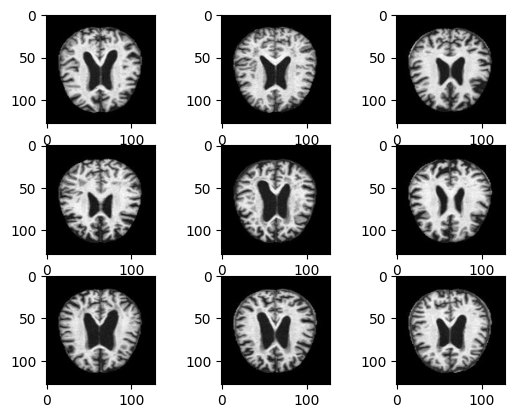

In [7]:
# plot first 9 images of the training dataset
for i in range(9):

    img_float64 = X_train[i].astype("float64")

    # define subplot
    plt.subplot(331 + i)
    # plot raw pixel data
    plt.imshow(img_float64, cmap=plt.get_cmap('gray'))
    
# show the figure
plt.show()

Categorize Data

In [8]:
Y_train = utils.to_categorical(Y_train_org, 4)
Y_val   = utils.to_categorical(Y_val_org, 4)
Y_test  = utils.to_categorical(Y_test_org, 4)

In [1]:
# # 128 * 128 = 16384
# X_train = X_train.reshape(X_train.shape[0], 16384)
# X_val   = X_val.reshape(X_val.shape[0], 16384)
# X_test  = X_test.reshape(X_test.shape[0], 16384)
               
# print("Number of training examples: ", X_train.shape[0],
#      "and the image is of the shape (%d)"%(X_train.shape[1]))
# print("Number of validating examples: ", X_val.shape[0],
#      "and the image is of the shape (%d)"%(X_val.shape[1]))
# print("Number of testing examples: ", X_test.shape[0],
#      "and the image is of the shape (%d)"%(X_test.shape[1]))

# print(X_test.shape)

In [9]:
model = Sequential(name="Sequential_CNN")

model.add(Conv2D(64, kernel_size=(3, 3),
                 padding="same",
                 activation="relu", input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2),
                       padding="valid"))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_3 (Dense)             (None, 256)               67109120  
                                                                 
 dense_4 (Dense)             (None, 16)                4112      
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                    

In [10]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
epochs     = 10
batch_size = 32
training = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_val,Y_val))

Epoch 1/10
 14/160 [=>............................] - ETA: 2:31 - loss: 1.0847 - accuracy: 0.4710

In [81]:
performance = model.evaluate(X_test, Y_test, verbose=0)

print("test score", performance[0]) 
print("test accuracy", performance[1])

test score 0.5211002230644226
test accuracy 0.7788162231445312


21/21 [==============================] - 1s 18ms/step


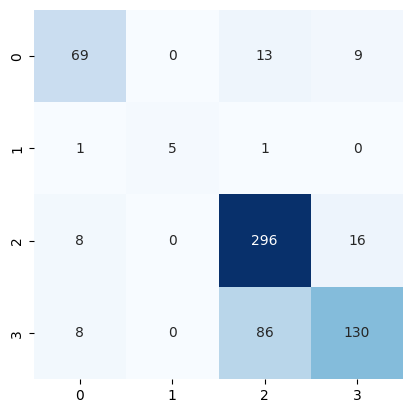

In [82]:
Y_pred   = model.predict(X_test)
Y_pred_c = np.argmax(Y_pred, axis=1)
Y_test_c = np.argmax(Y_test, axis=1)
matrix_confusion = confusion_matrix(Y_test_c, Y_pred_c)

sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False )
plt.show()

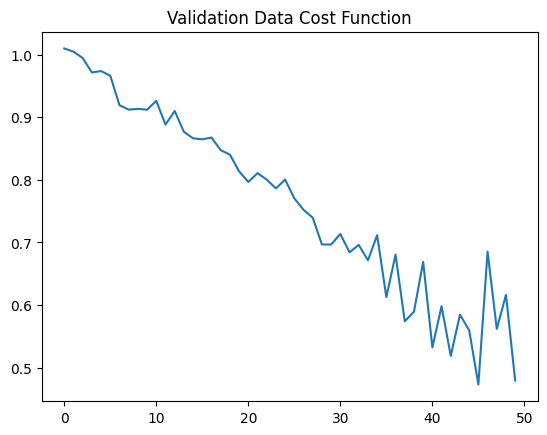

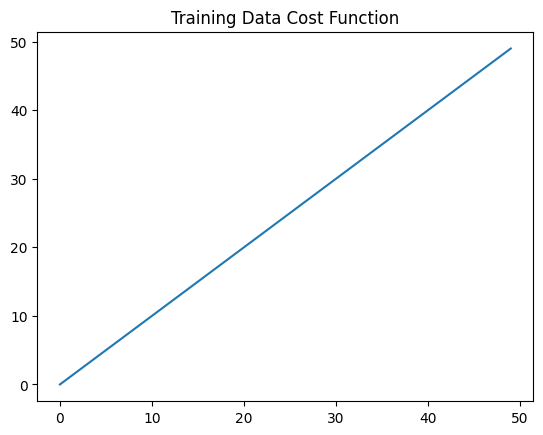

In [83]:
epoch_count = list(range(epochs))
#Tesing Data = Vaildation Data, lower is better
val_loss = training.history['val_loss']
#Training Data, lower is better
loss = training.history['loss']

plt.plot( epoch_count, val_loss )
plt.title('Validation Data Cost Function')
plt.show()
plt.plot( epoch_count,   )
plt.title('Training Data Cost Function')
plt.show()